# Elliptic Data Fraud Prediction 


## Dataset

The dataset for this project is the Elliptic Dataset, which records bitcoin transactions for the purpose of identifying licit vs ilicit bitcoin transactions.

## Sections
0. Introduction
1. Exploratory data analysis
2. Development of traditional machine learning models for licit vs ilicit classification
3. Development of deep learning models for licit vs ilicit classification
4. Results : Comparison of models 
5. Discussion & Limitations


## Elliptic Dataset Overview

The Elliptic Dataset is a graph network of Bitcoin transactions with handcrafted features. All features are constructed using only publicly available information.

The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:

- __Licit__: exchanges, wallet providers, miners, licit services, etc.
- __Ilicit__: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc
A given transaction is licit if the entity that generated it was licit.

- **Graph** 
  - __Nodes__ : 203,769 node transactions 
  - __Edges__ : 234,355 directed edge payments flows. 
  - 2% are ilicit (Class 1), 21% are licit (Class 2)

- __Features__ 166 features in each node.
  - 94 features : local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) 
    - normalized with range of numbers 
  - 72 features : aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of one hop neighbor transactions).
  - visible feature : Tx id, Time_stamp

- __Temporal Information__ 
  - 49 distinct timesteps evenly spaced with an interval of 2 weeks associated with each node, when the transaction is confirmed.


- __Data Files__
  - elliptic_txs_edgelist.csv contains graph edges information;
  - elliptic_txs_classes.csv contains information about legality of transactions;
  - elliptic_txs_features.csv contains information about transaction features; 


- __Data source__ M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.

# Loading libraries and data

In [ ]:
!pip install imblearn
!pip install pandasql
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
import numpy as np
import pandas as pd
import pandasql as pds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score,classification_report
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import networkx as nx

import os
import torch
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.pipeline import Pipeline
import torch.nn.functional as F





Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [ ]:
# Load data from Google drive (for using colab )
try:
    from google.colab import drive
    drive.mount('/content/drive')
    mount_flag = True
except ModuleNotFoundError:
    mount_flag = False
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the path for yours 

!ls "/content/drive/My Drive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project"

 1908.02591.pdf			 elliptic_txs_classes.csv
 CIS545_Project_combined.ipynb	 elliptic_txs_edgelist.csv
'CIS545 Project Proposal.pdf'	 elliptic_txs_features.csv
'Copy of CIS545 Project.ipynb'


In [ ]:
# Load raw data 

if mount_flag:
    classes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_classes.csv')
    features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_features.csv', header=None)
    edges = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CIS545_ Elliptic_Bitcoin Project/elliptic_txs_edgelist.csv')
else:
    classes = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
    features = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
    edges = pd.read_csv('../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

In [ ]:
# Rename columns : add features numbering and class description
features.columns = ["txId","time_step"] + ["x.{}".format(x) for x in range(1,features.shape[1]-1)]
classes["class_description"] = classes["class"].apply(lambda x : "unknown" if x == "unknown" else ("licit" if x == "2" else "illicit"))



In [ ]:

# Combine labels and features
df = features.merge(classes, on="txId")
labeled = df.loc[df["class"] != "unknown"]
unlabeled = df.loc[df["class"] == "unknown"]


# Exploratory Data Analysis


__Classes dataset__ 
We can see tha the dataset is quite imbalanced, with around 200k transactions but only about 25% of them are labeled, and of the 25% only around 2% of them are ilicit. The class imbalance may cause problems in the training of models later.

* 4545: illicit, 42019 : licit, and 157205 : unknown. (no null value)



In [ ]:
classes[['txId','class_description']].groupby('class_description').count()

,txId
class_description,
illicit,4545
licit,42019
unknown,157205


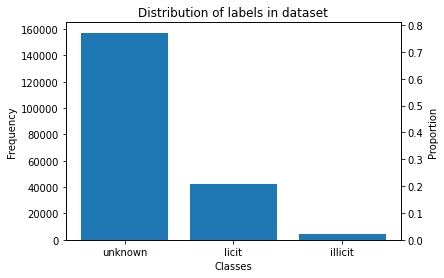

In [ ]:
fig, ax = plt.subplots()
ax.bar(classes["class_description"].unique(), classes["class_description"].value_counts())
ax.set_ylabel("Frequency")
ax.set_xlabel("Classes")
ax.set_title("Distribution of labels in dataset")
ax2 = ax.twinx()
ax2.bar(classes["class_description"].unique(), classes["class_description"].value_counts() / classes.shape[0])
ax2.set_ylabel("Proportion")
plt.show()


__Transaction Feature dataset__

We can see that there are 167 columns in the dataset with 165 of them being of float type whilst the remaining 2 integer types are the transaction ID and time step. 

However we are not given much meta data on what these features are or how they were collected.

  - 94 features are data collected around local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures). 72 features are obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of one hop neighbor transactions.
  - Only visible features are Tx id and Time_stamp

  - __neighbour_means__ : Additionally manipulated features ,  we took an advantage of graph data in Elliptic dataset. We combined in_ or out_bound transactions and get means values for all feature areas. 
    - NOTE : we use negighbour_means graphical features in the end indcluding all models.
  

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203769 entries, 0 to 203768
Columns: 167 entries, txId to x.165
dtypes: float64(165), int64(2)
memory usage: 259.6 MB


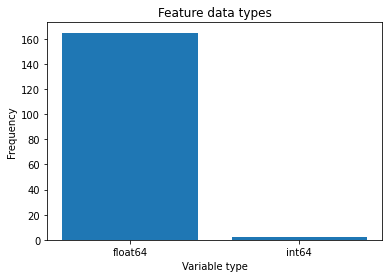

In [ ]:
plt.bar([str(x) for x in features.dtypes.value_counts().index], features.dtypes.value_counts())
plt.ylabel("Frequency")
plt.xlabel("Variable type")
plt.title("Feature data types")
plt.show()

__Edgelist dataset for graph__ 

*  txId1 : from node
*  txId2 : to node

In [ ]:
edges.head(3)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [ ]:
print('Total Num of Tx_nodes have out-going branch :',len(edges['txId1'].unique()))
print('Total Num of Tx_nodes have in-going branch :',len(edges['txId2'].unique()))

Total Num of Tx_nodes have out-going branch : 166345
Total Num of Tx_nodes have in-going branch : 148447


## Visualize the range of data in 'illicit' vs. 'licit' 

Due to large number of features, and also no contextual information given for each feature, a histogram is used instead of heatmap to visualise redundancy amongst the features. It appears most of the features are not strongly correlated to each other. However does not account for non-linear relationship.

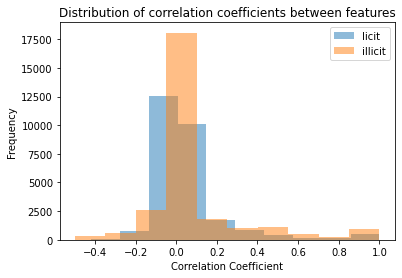

In [ ]:
plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].corr().to_numpy().flatten(), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].corr().to_numpy().flatten(), label="illicit", alpha=0.5)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of correlation coefficients between features")
plt.legend()
plt.show()

To visualise the range of data we plot distributions of the min, max, mean, and median. It appears that the features vary in scale but have been centered already, or by for some reason the features collected are all centered around 0.

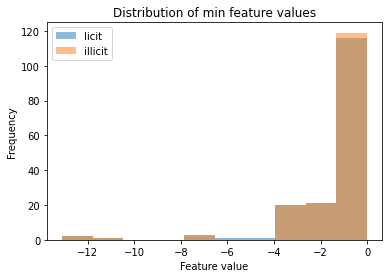

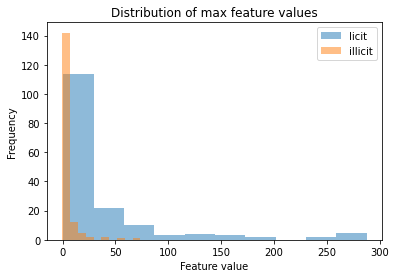

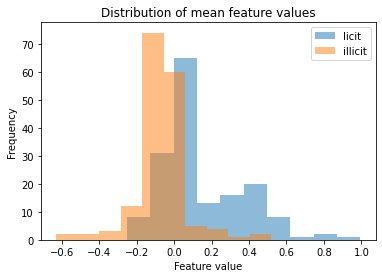

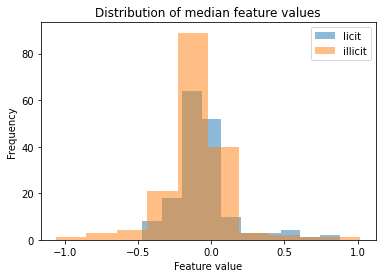

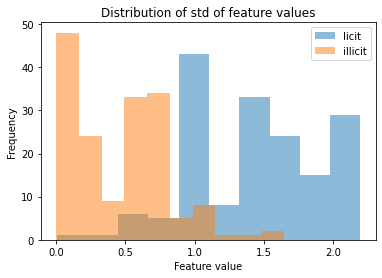

In [ ]:

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.min), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.min), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of min feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.max), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.max), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of max feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.mean), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.mean), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of mean feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.median), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.median), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of median feature values")
plt.legend()
plt.show()

plt.hist(labeled[(labeled['class_description']=='licit')].iloc[:,2:-2].apply(np.std), label="licit", alpha=0.5)
plt.hist(labeled[(labeled['class_description']=='illicit')].iloc[:,2:-2].apply(np.std), label="illicit", alpha=0.5)
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.title("Distribution of std of feature values")
plt.legend()
plt.show()

## Visualize the trends of transactions over time_stamp 

There are 49 time steps which are periods of 2 weeks of transactions.


- Labeled vs. unlabeled 
- illicit vs licit in labeled data 
- Ratio of illicit vs licit in labeled data
- Examples of distribution of feature values
- Example of graph visualization 

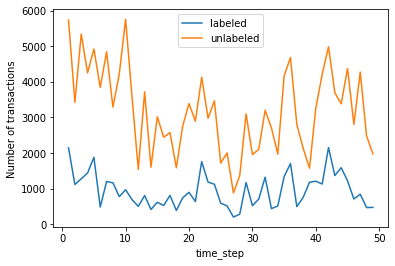

In [ ]:
labeled.groupby("time_step")["txId"].count().plot(label="labeled")
unlabeled.groupby("time_step")["txId"].count().plot(label="unlabeled")
plt.ylabel("Number of transactions")
plt.legend()
plt.show()

In [ ]:
# Fuction to draw ratio_graph over time_stamps between illicit vs. licit 

def ratio_graph(df):

  fig, ax = plt.subplots(2, 1, figsize=(10, 10))
  plt.subplots_adjust(hspace=0.4)

  
  temp_class = pd.crosstab(index=df['time_step'],columns=df['class_description'])
  temp_class.plot(kind='bar', stacked=True, ax=ax[0],\
                      title='Number of transactions per time interval', ylabel='Number of txs')
  
  
  temp_class_div = temp_class.div(temp_class.sum(1).astype(float),axis=0) 
  temp_class_div.plot(kind='bar', stacked=True,ax=ax[1], \
                      title='Percentage of transactions per time interval',ylabel='Pct of txs')

  # decrease number of ticks per x axis
  for i in range(len(ax)):
    for index, label in enumerate(ax[i].get_xticklabels()):
        if index % 4 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

  

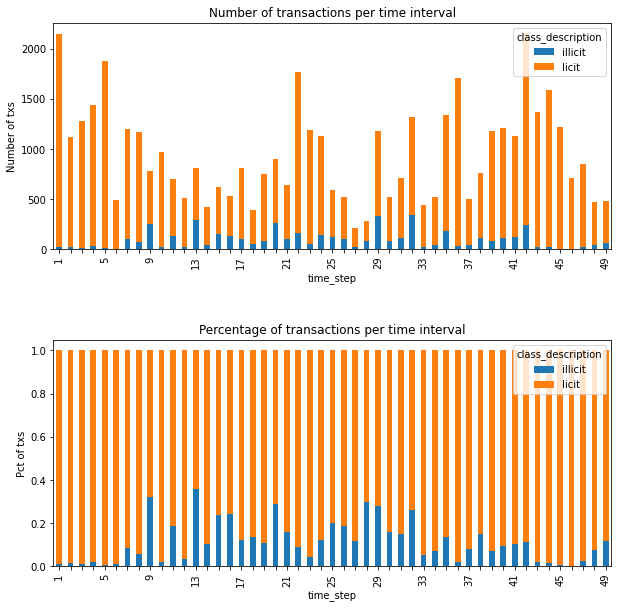

In [ ]:
ratio_graph(labeled)


__Example of data distributions in selected features.__

We select few features and visualize their distributions of illicit and licit data over time

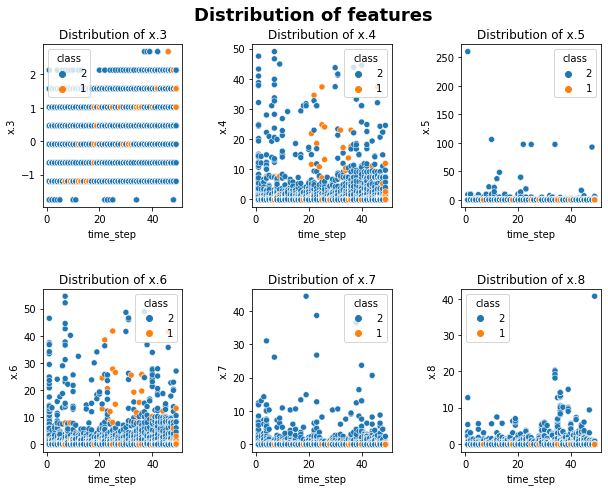

In [ ]:
# Representative distribution of features.

b=20
columns=labeled.columns
fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))
plt.subplots_adjust(wspace = 0.5, hspace=0.5)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')


ax = sns.scatterplot(ax = axes[0,0], data=labeled, y=columns[4],x='time_step',hue='class')
ax.set_title(f'Distribution of {columns[4]}')

ax1 = sns.scatterplot(ax = axes[0,1], data=labeled, y=columns[5],x='time_step',hue='class')
ax1.set_title(f'Distribution of {columns[5]}')

ax2 = sns.scatterplot(ax = axes[0,2], data=labeled, y=columns[6],x='time_step',hue='class')
ax2.set_title(f'Distribution of {columns[6]}')

ax3 = sns.scatterplot(ax = axes[1,0], data=labeled, y=columns[7],x='time_step',hue='class')
ax3.set_title(f'Distribution of {columns[7]}')

ax4 = sns.scatterplot(ax = axes[1,1], data=labeled, y=columns[8],x='time_step',hue='class')
ax4.set_title(f'Distribution of {columns[8]}')

ax5 = sns.scatterplot(ax = axes[1,2], data=labeled, y=columns[9],x='time_step',hue='class')
ax5.set_title(f'Distribution of {columns[9]}')

 

plt.show()

__Example of Graph visualization__

Elliptic dataset has graph data format for analyzing by Graph Convolutional Network. 
Here, we only visualize illicit transaction node from one time_step. 

In [ ]:
sample_ids = labeled.loc[(labeled['time_step'] ==18)  & (labeled['class']=='1'), 'txId']
short_edges = edges.loc[edges['txId1'].isin(sample_ids)]

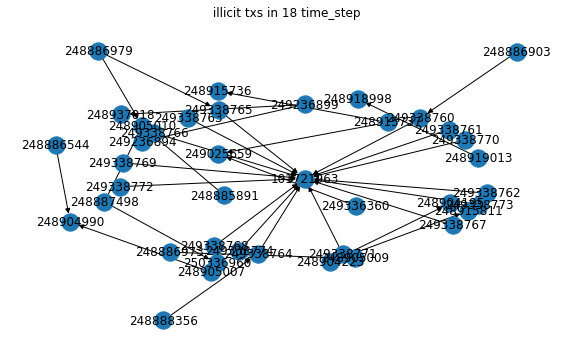

In [ ]:
import networkx as nx
fig, axe = plt.subplots(figsize=(10,6))
axe.set_title(' illicit txs in 18 time_step ')

graph = nx.from_pandas_edgelist(short_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph,ax=axe, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos )


## PCA 


### Visualising transactions 'licit' vs. 'illicit' with dimensionality reduction

 - Separation of licit and ilicit 
 - Proportion of variance
 - Accumulated variance


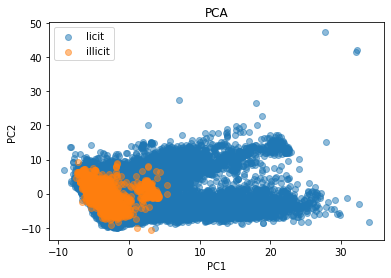

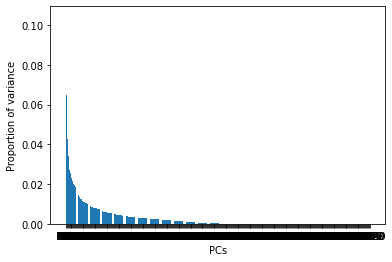

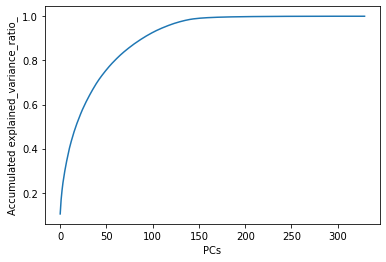

The total varience 0.9516338987258212
The number of components: 114


In [ ]:
pca = PCA()
ss = StandardScaler()
ss.fit(labeled.iloc[:,2:-2])
pca_features = pca.fit_transform(ss.transform(labeled.iloc[:,2:-2]))
plt.scatter(pca_features[labeled["class"]=="2"][:,0], pca_features[labeled["class"]=="2"][:,1], alpha=0.5, label="licit")
plt.scatter(pca_features[labeled["class"]=="1"][:,0], pca_features[labeled["class"]=="1"][:,1], alpha=0.5, label="illicit")
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


plt.bar(["PC{}".format(x) for x in range(1, pca_features.shape[1]+1)],pca.explained_variance_ratio_)
plt.ylabel("Proportion of variance")
plt.xlabel("PCs")
plt.show()

plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCs')
plt.ylabel('Accumulated explained_variance_ratio_')
plt.show()



var_cum = 0  # total varience from all components
num_comp = 0        # the number of components with 95% varience
for var in pca.explained_variance_ratio_:
    if var_cum > 0.95:
        print('The total varience', var_cum)
        print('The number of components:', num_comp)
        break
    else:
        var_cum += var
        num_comp += 1


# Simple supervised learning classifiers on Raw_data

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(labeled.iloc[:,2:-2], labeled["class"].apply(int), test_size=0.2, random_state=42)


Define the funcion for plotting confusion matrix

In [ ]:
import itertools

class_names = ['illicit', 'licit']
def plot_confusion_matrix(cm, class_names, title=None):
    plt.figure()
    
    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()
    plt.show()

## Logistic Regression

__On unscaled imbalanced data__

Logistic Regression_raw Model Evaluation: 
Final Test Accuracy: 96.3921
 Final F1 Score: 96.3026


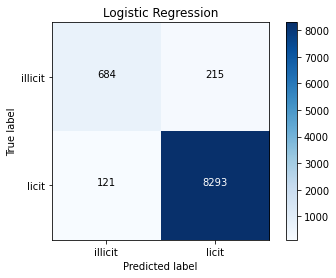

In [ ]:
logreg_raw = LogisticRegression(max_iter=10000)
logreg_raw.fit(X_train, y_train)
ypred_raw = logreg_raw.predict(X_test)

logreg_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'Logistic Regression_raw Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f}\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(logreg_raw_cm, class_names,'Logistic Regression' )

## SVC 
__On sacaled raw data with regularization parameter C = 15__ 

We tried optimization of SVC classifier with gridsearch, but there is issue with runnig time, and resampling process wasn't good process for this classifier. Thus we simply tested with fixed parameters after few screening. 

SVC_raw Model Evaluation: 
Final Train Accuracy: 98.0994,
 Final F1 Score: 98.0633


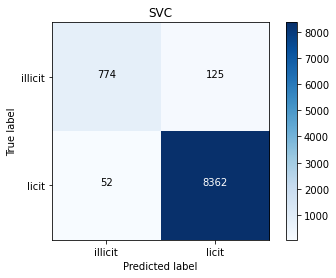

CPU times: user 58 s, sys: 131 ms, total: 58.2 s
Wall time: 1min 1s


In [ ]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svc_raw = make_pipeline(StandardScaler(), SVC(C = 15, gamma='auto'))
svc_raw.fit(X_train, y_train)
ypred_raw = svc_raw.predict(X_test)
svc_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'SVC_raw Model Evaluation: \n'
          f'Final Train Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(svc_raw_cm, class_names,'SVC' )


## RandomForest Classifier 
__on imbalanced raw data__

RF_raw Model Evaluation: 
Final Test Accuracy: 98.8403,
 Final F1 Score: 98.8090


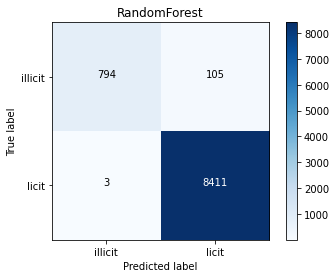

In [ ]:
rfc_raw = RandomForestClassifier()
rfc_raw.fit(X_train, y_train)
ypred_raw = rfc_raw.predict(X_test)
rfc_raw_cm= confusion_matrix(y_test, ypred_raw)

print(f'RF_raw Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_raw):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_raw, average="weighted"):.4f}')

plot_confusion_matrix(rfc_raw_cm, class_names,'RandomForest' )


## AdaBoostClassifier
__On imbalanced raw data__


AdaBoost Model Evaluation: 
Final Test Accuracy: 98.9048,
 Final F1 Score: 98.8919


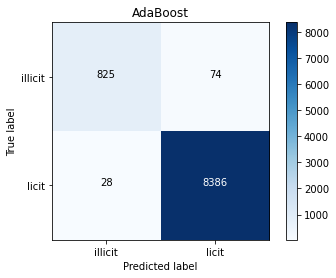

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 150 , random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(labeled.iloc[:,2:-2], labeled["class"].apply(int), test_size=0.2, random_state=42)

ada.fit(X_train, y_train)
ypred_ada = ada.predict(X_test)
ada_cm = confusion_matrix(y_test, ypred_ada)

print(f'AdaBoost Model Evaluation: \n'
          f'Final Test Accuracy: {100.* accuracy_score(y_test, ypred_ada):.4f},\n',
          f'Final F1 Score: {100.* f1_score(y_test, ypred_ada, average="weighted"):.4f}')

plot_confusion_matrix(ada_cm, class_names,'AdaBoost' )


## ROC Curve Comparison for LR, SVC, RF, ABC on imbalanced data

*Resampling* methods are not efficient in the learning models we have investigated. 

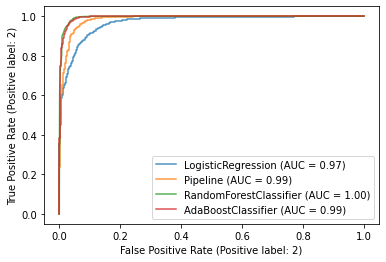

In [ ]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
Log_disp = RocCurveDisplay.from_estimator(logreg_raw, X_test, y_test, ax=ax, alpha=0.8)
svc_disp = RocCurveDisplay.from_estimator(svc_raw, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp = RocCurveDisplay.from_estimator(rfc_raw, X_test, y_test, ax=ax, alpha=0.8)
ada_disp = RocCurveDisplay.from_estimator(ada, X_test, y_test, ax=ax, alpha=0.8)

plt.show()

## Unsupervised learning : K-means

Use K-means to find out the natural 2 clusters in the dataset. 
We will use two mean points from each labeled class to initialize centroids.

In [ ]:
from sklearn.cluster import KMeans
ss = StandardScaler()
X = ss.fit_transform(df.iloc[:,2:-2])

def init_centroids(X, n_clusters, random_state):
    # Initialize cluster centroids as random points of each class from labeled data
    num_1 = X[df['class'] == '1'].shape[0]
    num_2 = X[df['class'] == '2'].shape[0]
    init_1 = X[df['class'] == '1'][np.random.randint(num_1)]
    init_2 = X[df['class'] == '2'][np.random.randint(num_2)]

    init = pd.DataFrame([init_1, init_2])
    return init

kmeans = KMeans(n_clusters=2, n_init = 10, init = init_centroids, algorithm = 'auto').fit(X)

In [ ]:
# Compare predicted labels with actual
class_predicted = kmeans.labels_
class_actual = labeled['class'].apply(int)
print('Correctly predicted lables = ', (class_predicted[class_actual.index] == class_actual).sum())
print('The number of transactions labeled as 1 = ', class_predicted.sum())

Correctly predicted lables =  8
The number of transactions labeled as 1 =  12272


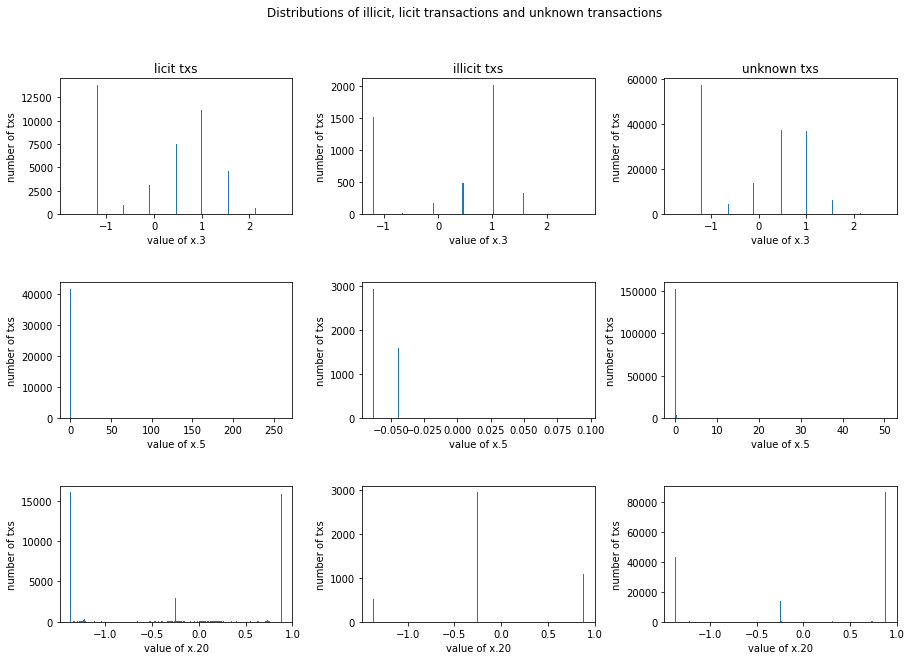

In [ ]:
# Show distributions of various features.

density = False # Show distributions rather than frequencies if True
bins = 200

fig,axes = plt.subplots(3,3, figsize = (15,10))
plt.subplots_adjust(wspace = 0.3, hspace=0.5)
fig.suptitle('Distributions of illicit, licit transactions and unknown transactions')

k = 3 # x.3
x_licit = labeled[(labeled['class_description']=='licit')].iloc[:,k+1]
x_illicit = labeled[(labeled['class_description']=='illicit')].iloc[:,k+1]
x_unknown = unlabeled.iloc[:,k+1]

ax1 = axes[0,0]
ax1.hist(x_licit, bins = bins, density = density)
ax1.set(xlabel = f'value of x.{k}')
ax1.set(ylabel = 'number of txs')
ax1.set_title('licit txs')

ax2 = axes[0,1]
ax2.hist(x_illicit, bins = bins, density = density)
ax2.set(xlabel = f'value of x.{k}')
ax2.set(ylabel = 'number of txs')
ax2.set_title('illicit txs')

ax_02 = axes[0,2]
ax_02.hist(x_unknown, bins = bins, density = density)
ax_02.set(xlabel = f'value of x.{k}')
ax_02.set(ylabel = 'number of txs')
ax_02.set_title('unknown txs')

k = 5 # x.5
x_licit = labeled[(labeled['class_description']=='licit')].iloc[:,k+1]
x_illicit = labeled[(labeled['class_description']=='illicit')].iloc[:,k+1]
x_unknown = unlabeled.iloc[:,k+1]

ax3 = axes[1,0]
ax3.hist(x_licit, bins = bins, density = density)
ax3.set(xlabel = f'value of x.{k}')
ax3.set(ylabel = 'number of txs')

ax4 = axes[1,1]
ax4.hist(x_illicit, bins = bins, density = density)
ax4.set(xlabel = f'value of x.{k}')
ax4.set(ylabel = 'number of txs')

ax_12 = axes[1,2]
ax_12.hist(x_unknown, bins = bins, density = density)
ax_12.set(xlabel = f'value of x.{k}')
ax_12.set(ylabel = 'number of txs')


k = 20 # x.20
x_licit = labeled[(labeled['class_description']=='licit')].iloc[:,k+1]
x_illicit = labeled[(labeled['class_description']=='illicit')].iloc[:,k+1]
x_unknown = unlabeled.iloc[:,k+1]

ax5 = axes[2,0]
ax5.hist(x_licit, bins = bins, density = density)
ax5.set(xlabel = f'value of x.{k}')
ax5.set(ylabel = 'number of txs')

ax6 = axes[2,1]
ax6.hist(x_illicit, bins = bins, density = density)
ax6.set(xlabel = f'value of x.{k}')
ax6.set(ylabel = 'number of txs')

ax_21 = axes[2,2]
ax_21.hist(x_unknown, bins = bins, density = density)
ax_21.set(xlabel = f'value of x.{k}')
ax_21.set(ylabel = 'number of txs')

plt.show()

The significant difference in intervals of variables suggests that some data are irrelevant.

In [ ]:
print('The max value of x.5 for illicit class: ',\
      labeled[labeled['class_description'] == 'illicit'].iloc[:,6].max())
print('The max value of x.5 for licit class: ', \
      labeled[labeled['class_description'] == 'licit'].iloc[:,6].max())

The max value of x.5 for illicit class:  0.09507562933306678
The max value of x.5 for licit class:  260.0907072901824


Conclusion : 
Some features of licit and illicit transactions have different distributions. One can use this observation to build a more efficient clustering algorithm. 

# Building classifiers
Based on the exploratory analysis, there are several challenges. Firstly, there is a large amount of unlabeled data, which will not be usable for supervised learning. Secondly, within the labeled data, there is significant imbalance in the class labels which could affect training. Lastly, with PCA in 2 dimensions, there is no good separation of licit vs ilicit classes which could mean that classification might be challenging.

Although there are many aspects of the classifier pipeline that could be searched through, we will be limiting ourselves to the following options given the limited time.

## Class balance
During training, an imbalance in classes could affect the resulting metrics on test data. In this case we will compare 2 options
1. No change in class balance
2. Random over sampling

## Feature representation
The feature inputs to models can significantly affect performance. There are various pre-processing steps that could be used such as feature selection via thresholding methods, mutual information, dimensionality reduction and so on. For the purposes of this assignment we will be attempting the following
1. No change in base features
2. PCA with cut off based on 95% variation captured
3. Feature engineering to incorporate graph structure

## Classifier type
There are a large number of possible classifiers to attempt, but we have chosen 3 main types taking into account computational time required. However we also added some other analysis for general comparison (including SVC, AdaBoost, Kmeans)

1. Logistic Regression
2. Random Forest
3. Graph Neural Networks

These 3 classifiers were chosen because they represent a good spread of approaches. Logistic regression is the simplest and will provide a baseline for comparison, representing some of the most traditional machine learning approaches. Random forest models is a step up in complexity, still within traditional machine learning approaches, but applying concepts such as bagging and ensemble learning. Lastly, graph neural networks are a more recent development applying deep learning approaches to leverage graph structure in a more flexible way than manually engineered features.




# Results



## Summary
In summary, the pipelines we will be attempting are as follows
1. Base features + logistic regression
2. Base features + over sampling + logistic regression
3. PCA on base features + logistic regression
4. PCA on base features + over sampling + logistic regression
5. Base and graph features + logistic regression
6. Base and graph features + over sampling + logistic regression
7. PCA on base and graph features + logistic regression
8. PCA on base and graph features + over sampling + logistic regression

==========================================================='
9. Base features + random forest
10. Base features + over sampling + random forest
11. PCA on base features + random forest
12. PCA on base features + over sampling + random forest
13. Base and graph features + random forest
14. Base and graph features + over sampling + random forest
15. PCA on base and graph features + random forest
16. PCA on base and graph features + over sampling + random forest

==========================================================='
17. Base features + graph convolution network

Additionally, each classifier will have hyperparameters tuned using gridsearch cv or some other manual search method.

## Evaluation
Accuracy, precision, recall, and F1 score will be calculated on test set for each model, but F1 score will be preferred as the data set is inherently imbalanced and in these cases accuracy and other metrics do not provide as robust a metric as F1.


## Development of deep learning model

We build simple GCN model and reported the results are cominbed with all other classifiers in Result Section.


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, out_c):
        super().__init__()
        self.conv1 = GCNConv(dl_data.num_node_features, out_c)
        self.conv2 = GCNConv(out_c, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


__Preparing the data for overall comparison__

In [ ]:
%%time
#######################################################
# Preparing the data for overall comparison and GCN #
#######################################################

def getPCA(data, threshold):
    ss = StandardScaler()
    pca = PCA()
    output = pca.fit_transform(ss.fit_transform(data))
    idx = np.argmax(np.cumsum(pca.explained_variance_ratio_) > threshold)
    return output[:,:idx+1], pca, ss

# Create masks for train and test data
train_mask, test_mask = train_test_split(range(labeled.shape[0]), random_state=42)

# Create base feature train test
base_x_train = labeled.iloc[train_mask, 2:-2]
base_y_train = labeled.iloc[train_mask, -2].apply(int) - 1
base_x_test = labeled.iloc[test_mask, 2:-2]
base_y_test = labeled.iloc[test_mask, -2].apply(int) - 1

# Create PCA on base features train test
base_pca_x_train, base_pca_model, base_ss_model = getPCA(labeled.iloc[train_mask, 2:-2], 0.95)
base_pca_y_train = base_y_train
base_pca_x_test = base_pca_model.transform(base_ss_model.transform(base_x_test))
base_pca_y_test = base_y_test

# Attempt to create features to include graph structure by taking mean of first degree neighbours of each node
labeled_edges = labeled[["txId"]].merge(pds.sqldf("SELECT * FROM edges_undirected WHERE txId1 IN (SELECT txId FROM labeled) AND txId2 IN (SELECT txId FROM labeled)", globals()), how="left", left_on="txId", right_on="txId1")
neighbour_means = labeled_edges.merge(labeled, how="left", left_on="txId2", right_on="txId").groupby("txId_x")[["x.{}".format(i) for i in range(1,166)]].mean().reset_index()
neighbour_means[neighbour_means.isnull()] = 0
neighbour_means.columns = ["txId"] + ["x.neighbour.mean.{}".format(i) for i in range(1,166)]
labeled_graph = labeled.merge(neighbour_means, on="txId")

# Create graph features train test
graph_x_train = labeled_graph.iloc[train_mask, 2:].drop(["class","class_description"], axis=1)
graph_y_train = base_y_train
graph_x_test = labeled_graph.iloc[test_mask, 2:].drop(["class","class_description"], axis=1)
graph_y_test = base_y_test

# Create PCA on graph features train test
graph_pca_x_train, graph_pca_model, graph_ss_model = getPCA(labeled_graph.iloc[train_mask, 2:].drop(["class","class_description"], axis=1), 0.95)
graph_pca_y_train = base_y_train
graph_pca_x_test = graph_pca_model.transform(graph_ss_model.transform(labeled_graph.iloc[test_mask, 2:].drop(["class","class_description"], axis=1)))
graph_pca_y_test = base_y_test

# Create deep learning dataset
lookup = dict(zip(labeled["txId"].to_numpy(), range(labeled.shape[0])))
labeled_edges = labeled_edges.drop("txId", axis=1).dropna()
labeled_edges = labeled_edges.applymap(lambda x : lookup[x])
xs = torch.tensor(labeled.iloc[:,2:-2].to_numpy(), dtype=torch.float)
edge_list = add_self_loops(torch.tensor(labeled_edges.T.to_numpy(), dtype=torch.long))[0]
dl_data = Data(x=xs, edge_index=edge_list, y=torch.tensor(labeled["class"].to_numpy(dtype=np.int)-1, dtype=torch.long))

In [ ]:
%%time
models= {}

# Logistic regression on base features with no oversampling
hyper_parameters = {"penalty" : ["none", "l1", "l2", "elasticnet"]}

lr_base = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_base.fit(base_x_train, base_y_train)
models["lr_base"] = lr_base

# Logistic regression on base features with oversampling
rus = RandomOverSampler(random_state=42)
base_x_oversample, base_y_oversample = rus.fit_resample(base_x_train, base_y_train)
lr_base_oversample = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_base_oversample.fit(base_x_oversample, base_y_oversample)
models["lr_base_oversample"] = lr_base_oversample

# Logistic regression on base pca features with no oversampling
lr_base_pca = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_base_pca.fit(base_pca_x_train, base_pca_y_train)
models["lr_base_pca"] = lr_base_pca

# Logistic regression on base pca features with oversampling
rus = RandomOverSampler(random_state=42)
base_pca_x_oversample, base_pca_y_oversample = rus.fit_resample(base_pca_x_train, base_pca_y_train)
lr_base_pca_oversample = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_base_pca_oversample.fit(base_pca_x_oversample, base_pca_y_oversample)
models["lr_base_pca_oversample"] = lr_base_pca_oversample

# Logistic regression on graph features with no oversampling
lr_graph = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_graph.fit(graph_x_train, graph_y_train)
models["lr_graph"] = lr_graph

# Logistic regression on graph features with oversampling
rus = RandomOverSampler(random_state=42)
graph_x_oversample, graph_y_oversample = rus.fit_resample(graph_x_train, graph_y_train)
lr_graph_oversample = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_graph_oversample.fit(graph_x_oversample, graph_y_oversample)
models["lr_graph_oversample"] = lr_graph_oversample

# Logistic regression on graph pca features with no oversampling
lr_graph_pca = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_graph_pca.fit(graph_pca_x_train, graph_pca_y_train)
models["lr_graph_pca"] = lr_graph_pca

# Logistic regression on graph pca features with oversampling
rus = RandomOverSampler(random_state=42)
graph_pca_x_oversample, graph_pca_y_oversample = rus.fit_resample(graph_pca_x_train, graph_pca_y_train)
lr_graph_pca_oversample = GridSearchCV(LogisticRegression(solver="saga", l1_ratio=0.5), param_grid=hyper_parameters, verbose=2)
lr_graph_pca_oversample.fit(graph_pca_x_oversample, graph_pca_y_oversample)
models["lr_graph_pca_oversample"] = lr_graph_pca_oversample


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   7.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  10.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  23.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  18.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  10.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   9.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  12.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=  10.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  14.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  20.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  18.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  18.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  18.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  13.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  13.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=  13.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  18.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  19.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  18.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  18.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=  18.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   4.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   4.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  19.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  12.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  19.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  19.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  19.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  19.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=  19.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  22.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  22.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  22.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  22.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  34.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  35.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  35.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  35.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  35.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  22.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=  22.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=  22.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  35.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  35.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  35.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  36.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=  35.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   6.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=   7.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .......................................penalty=none; total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  12.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l1; total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   9.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


[CV] END .........................................penalty=l2; total time=   9.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .........................................penalty=l2; total time=   9.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  12.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .................................penalty=elasticnet; total time=  12.6s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty)


[CV] END .................................penalty=elasticnet; total time=  12.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [ ]:
# Random forest on base features with no oversampling
hyper_parameters = {"max_features" : ["sqrt", "log2"],
                    "criterion" : ["gini", "entropy"],
                    "n_estimators" : [50, 100, 150]}

rf_base = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_base.fit(base_x_train, base_y_train)
models["rf_base"] = rf_base

# Random forest on base features with oversampling
rus = RandomOverSampler(random_state=42)
base_x_oversample, base_y_oversample = rus.fit_resample(base_x_train, base_y_train)
rf_base_oversample = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_base_oversample.fit(base_x_oversample, base_y_oversample)
models["rf_base_oversample"] = rf_base_oversample

# Random forest on base pca features with no oversampling
rf_base_pca = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_base_pca.fit(base_pca_x_train, base_pca_y_train)
models["rf_base_pca"] = rf_base_pca

# Random forest on base pca features with oversampling
rus = RandomOverSampler(random_state=42)
base_pca_x_oversample, base_pca_y_oversample = rus.fit_resample(base_pca_x_train, base_pca_y_train)
rf_base_pca_oversample = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_base_pca_oversample.fit(base_pca_x_oversample, base_pca_y_oversample)
models["rf_base_pca_oversample"] = rf_base_pca_oversample

# Random forest on graph features with no oversampling
rf_graph = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_graph.fit(graph_x_train, graph_y_train)
models["rf_graph"] = rf_graph

# Random forest on graph features with oversampling
rus = RandomOverSampler(random_state=42)
graph_x_oversample, graph_y_oversample = rus.fit_resample(graph_x_train, graph_y_train)
rf_graph_oversample = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_graph_oversample.fit(graph_x_oversample, graph_y_oversample)
models["rf_graph_oversample"] = rf_graph_oversample

# Random forest on graph pca features with no oversampling
rf_graph_pca = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_graph_pca.fit(graph_pca_x_train, graph_pca_y_train)
models["rf_graph_pca"] = rf_graph_pca

# Random forest on graph pca features with oversampling
rus = RandomOverSampler(random_state=42)
graph_pca_x_oversample, graph_pca_y_oversample = rus.fit_resample(graph_pca_x_train, graph_pca_y_train)
rf_graph_pca_oversample = GridSearchCV(RandomForestClassifier(), param_grid=hyper_parameters, verbose=2)
rf_graph_pca_oversample.fit(graph_pca_x_oversample, graph_pca_y_oversample)
models["rf_graph_pca_oversample"] = rf_graph_pca_oversample


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .criterion=gini, max_features=sqrt, n_estimators=50; total time=   6.1s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=50; total time=   6.1s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=50; total time=   6.0s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=50; total time=   6.1s
[CV] END .criterion=gini, max_features=sqrt, n_estimators=50; total time=   6.0s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  11.9s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  12.0s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  11.8s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  12.0s
[CV] END criterion=gini, max_features=sqrt, n_estimators=100; total time=  12.1s
[CV] END criterion=gini, max_features=sqrt, n_estimators=150; total time=  17.9s
[CV] END criterion=gini, max_features=sqrt, n_es

In [ ]:

lrs = [0.01, 0.001, 0.0001]
out_cs = [16, 32, 48]
dl_models = []
for lr in lrs:
    for out_c in out_cs:
        print("Training model with out_c={} and learning rate={}".format(out_c, lr))
        scores = {}
        scores["lr"] = lr
        scores["out_c"] = out_c
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN(out_c).to(device)
        data = dl_data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

        model.train()
        for epoch in range(200):
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[train_mask], data.y[train_mask])
            loss.backward()
            optimizer.step()

        model.eval()
        pred = model(data).argmax(dim=1)
        scores["test_acc"] = accuracy_score(pred[test_mask], data.y[test_mask])
        scores["test_recall"] = recall_score(pred[test_mask], data.y[test_mask])
        scores["test_precision"] = precision_score(pred[test_mask], data.y[test_mask])
        scores["test_f1"] = f1_score(pred[test_mask], data.y[test_mask])
        dl_models.append(scores)
dl_models = pd.DataFrame(dl_models)

Training model with out_c=16 and learning rate=0.01
Training model with out_c=32 and learning rate=0.01
Training model with out_c=48 and learning rate=0.01
Training model with out_c=16 and learning rate=0.001
Training model with out_c=32 and learning rate=0.001
Training model with out_c=48 and learning rate=0.001
Training model with out_c=16 and learning rate=0.0001
Training model with out_c=32 and learning rate=0.0001
Training model with out_c=48 and learning rate=0.0001


In [ ]:
evaluations = []
for k,v in models.items():
    scores = {}
    scores["clf"] = k
    scores["params"] = v.best_params_
    if k.find("base_pca") > -1:
        ypred = v.best_estimator_.predict(base_pca_x_test[:,:base_pca_x_train.shape[1]])
        scores["test_acc"] = accuracy_score(ypred, base_y_test)
        scores["test_recall"] = recall_score(ypred, base_y_test)
        scores["test_precision"] = precision_score(ypred, base_y_test)
        scores["test_f1"] = precision_score(ypred, base_y_test)
    elif k.find("base") > -1:
        ypred = v.best_estimator_.predict(base_x_test)
        scores["test_acc"] = accuracy_score(ypred, base_y_test)
        scores["test_recall"] = recall_score(ypred, base_y_test)
        scores["test_precision"] = precision_score(ypred, base_y_test)
        scores["test_f1"] = precision_score(ypred, base_y_test)
    elif k.find("graph_pca") > -1:
        ypred = v.best_estimator_.predict(graph_pca_x_test[:,:graph_pca_x_train.shape[1]])
        scores["test_acc"] = accuracy_score(ypred, base_y_test)
        scores["test_recall"] = recall_score(ypred, base_y_test)
        scores["test_precision"] = precision_score(ypred, base_y_test)
        scores["test_f1"] = precision_score(ypred, base_y_test)
    elif k.find("graph") > -1:
        ypred = v.best_estimator_.predict(graph_x_test)
        scores["test_acc"] = accuracy_score(ypred, base_y_test)
        scores["test_recall"] = recall_score(ypred, base_y_test)
        scores["test_precision"] = precision_score(ypred, base_y_test)
        scores["test_f1"] = precision_score(ypred, base_y_test)
    evaluations.append(scores)
evaluation_df = pd.DataFrame(evaluations)


## Deep learning model scores

In [ ]:
dl_models.sort_values("test_f1", ascending=False)

,lr,out_c,test_acc,test_recall,test_precision,test_f1
2,0.0100,48,0.966584,0.970703,0.992843,0.981648
1,0.0100,32,0.965037,0.969251,0.992652,0.980812
0,0.0100,16,0.959196,0.963921,0.991793,0.977659
5,0.0010,48,0.957306,0.961702,0.992079,0.976655
4,0.0010,32,0.954471,0.958437,0.992461,0.975152
3,0.0010,16,0.940040,0.948876,0.986545,0.967344
8,0.0001,48,0.915815,0.925697,0.985590,0.954705
7,0.0001,32,0.787647,0.930160,0.826128,0.875063
6,0.0001,16,0.487157,0.960572,0.448707,0.611682


## Classical model scores

In [ ]:
evaluation_df.sort_values("test_f1", ascending=False)

,clf,params,test_acc,test_recall,test_precision,test_f1
8,rf_base,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.987115,0.986254,0.999618,0.999618
12,rf_graph,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.986857,0.986067,0.999523,0.999523
9,rf_base_oversample,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.989004,0.988762,0.999141,0.999141
13,rf_graph_oversample,"{'criterion': 'gini', 'max_features': 'log2', ...",0.986857,0.986433,0.999141,0.999141
10,rf_base_pca,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.972683,0.972649,0.997710,0.997710
14,rf_graph_pca,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.964522,0.964470,0.997328,0.997328
11,rf_base_pca_oversample,"{'criterion': 'entropy', 'max_features': 'log2...",0.974057,0.974806,0.996946,0.996946
15,rf_graph_pca_oversample,"{'criterion': 'entropy', 'max_features': 'log2...",0.967786,0.969081,0.995992,0.995992
2,lr_base_pca,{'penalty': 'none'},0.910403,0.915463,0.992079,0.992079
6,lr_graph_pca,{'penalty': 'none'},0.918306,0.925813,0.988453,0.988453


# Discussion

### Overall ranking
Overall the best classifiers are random forest classifiers, which is in keeping with the findings published along with the original dataset. Logistic regression performs remarkably well, outcompeting the graph convolutional networks. However, optimising the graph convolutional network hyperparameters is likely more challenging that for logistic regression and the random forest. Based on the space sampled thus far, it appears that there is still room for improvement, as increasing the output channel dimensions has a positive effect on the F1 score, and it has not yet reached a plateau. Additionally, the models may not have completed training, as the increase in learning rate for 200 epochs still provides increased performance.

### Effect of oversampling
In all cases the use of oversampling to during training results in worse performance.

### Effect of dimensionality reduction
In all cases the use of PCA to construct orthogonal features and reduce dimensionality results in worse performance.

### Effect of manual graph features
In most cases, the addition of graph features as created by taking the mean of each feature of a nodes first degree neighbours did not result in significant improvement in F1 score. This is likely because the existing features already include some graph related features such as in and out degree.

# Limitations

Due to time limitations, full exploration of each model was not possible, particularly for the deep learning approach. Furthermore, the fact that random forests can perform at such a high level on this data set also suggests that any classifier would be hitting some hard limit of performance ceiling, as the difference in performance between each classifier is minimal.